In [1]:
import numpy as np
import xarray as xr
import os
import sys
sys.path.append("../")
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.data_utils import *        

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = "../data/"

time_start = "2017-01-01"
time_end = "2022-12-31"

zarr_ds = load_data(data_dir, time_start=time_start, time_end=time_end)

In [3]:
batch_size = 32
train_loader, test_loader = get_data_loaders(zarr_ds, 0.8, batch_size=batch_size)

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
x, y = next(iter(train_loader))
x = x.to(device)

In [10]:
from src.vae_model import *
from tqdm import tqdm

In [11]:
model = ConvVAE(input_channels=10, latent_dim=8).to(device)
model.compile()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
kl_lambda = 0.5

In [12]:
train_rec_losses, train_kl_losses, val_losses = train(
    model,
    opt,
    train_loader,
    test_loader,
    device,
    kl_lambda=kl_lambda,
    num_epochs=50,
    show_every=10,
)

Training epoch 1:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10/50: Train loss: 0.0309 | 0.0215, Val loss: 0.0543


Epoch 20/50: Train loss: 0.0288 | 0.0025, Val loss: 0.0446


Epoch 30/50: Train loss: 0.0282 | 0.0066, Val loss: 0.0407


Epoch 40/50: Train loss: 0.0278 | 0.0013, Val loss: 0.0413


Epoch 50/50: Train loss: 0.0274 | 0.0006, Val loss: 0.0388


In [13]:
torch.cuda.empty_cache()
x, y = next(iter(test_loader))
x = x.to(device)
y = y.to(device)
xy = torch.cat((x, y.unsqueeze(1)), dim=1)
with torch.no_grad():
    xhat, mu, logvar = model(xy)

In [15]:
xhat = xhat.detach().cpu().numpy()

In [22]:
def plot_channels(x):
    fig, axs = plt.subplots(3, 3)
    for i, ax in enumerate(axs.ravel()):
        ax.imshow(x[0, i, :, :], clim=(0, 1))
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

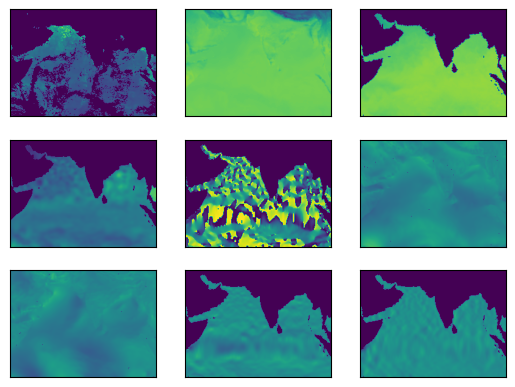

In [24]:
plot_channels(x.cpu())

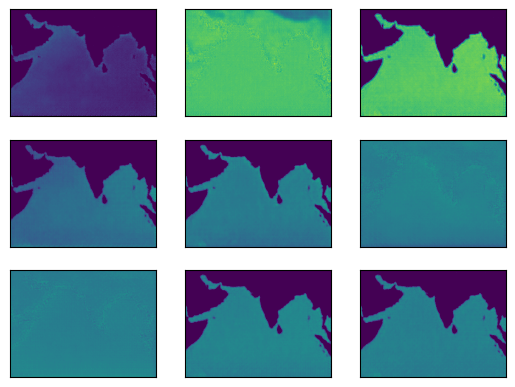

In [23]:
plot_channels(xhat)